<a href="https://colab.research.google.com/github/pikawangwang/Time-series/blob/main/TiDEMulti2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ray
!pip install pytorch_lightning
!pip install darts

In [166]:
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection
from darts.dataprocessing.transformers import Scaler
from darts.models import TiDEModel
from darts import TimeSeries, concatenate
from sklearn.preprocessing import MinMaxScaler

In [167]:
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd

In [168]:
# 設定callback
class LossLoggingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.losses = []

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics["val_loss"].item()
        self.losses.append(val_loss)
        print(f"Epoch {trainer.current_epoch}: val_loss={val_loss}")


### Data preprocess

In [169]:
# 步骤1: 加载CSV文件
df = pd.read_csv('/content/EDvisitfile.csv')

# 步骤2: 使用MinMaxScaler缩放数据
scaler = MinMaxScaler()

# 对 'No'列进行scaling
columns_to_scale = ['No']
df_scaled = df.copy()  # 创建数据副本进行缩放
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


# 步骤4: 将处理后的DataFrame转换为TimeSeries
series = TimeSeries.from_dataframe(df_scaled, 'date', 'No')
series_origin = TimeSeries.from_dataframe(df, 'date', 'No')
Weekdayseries = TimeSeries.from_dataframe(df_scaled, 'date', 'Weekday')
Dayoffseries = TimeSeries.from_dataframe(df_scaled, 'date', 'Dayoff')
ED_covariates = Weekdayseries.stack(Dayoffseries)

In [170]:
#Spilt data
train_proportion = 0.5
val_proportion = 0.4

# Calculate the split indices
train_end = int(len(series) * train_proportion)
val_end = train_end + int(len(series) * val_proportion)

# Split the list
train, val, test, = series[:train_end], series[train_end:val_end], series[val_end:],
train_origin, val_origin, test_origin = series_origin[:train_end], series_origin[train_end:val_end], series_origin[val_end:],

### Training

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type             | Params
---------------------------------------------------------
0 | criterion           | MSELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | past_cov_projection | _ResidualBlock   | 1.8 K 
4 | encoders            | Sequential       | 3.2 M 
5 | decoders            | Sequential       | 726 K 
6 | temporal_decoder    | _ResidualBlock   | 1.1 K 
7 | lookback_skip       | Linear           | 43.2 K
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: val_loss=0.06450011233763402


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: val_loss=0.0201963668418776


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: val_loss=0.015775880441083974


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: val_loss=0.016072939295025897


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: val_loss=0.016143061485328895


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: val_loss=0.015727261739367785


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: val_loss=0.016114285886528704


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: val_loss=0.017823179824218868


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: val_loss=0.01772256354176407


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: val_loss=0.017065280212860027


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: val_loss=0.017414372084377846


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: val_loss=0.018081467455061066


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: val_loss=0.01772052514686471


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: val_loss=0.017672234892937032


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: val_loss=0.01773470819922122


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: val_loss=0.017689885091161723


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: val_loss=0.018494243468967532


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: val_loss=0.01823354721898047


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: val_loss=0.017633777920876195


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: val_loss=0.017969023638595347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: val_loss=0.01808752357084835


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: val_loss=0.018791008311090235


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: val_loss=0.01773266419401189


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: val_loss=0.018568785069010954


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: val_loss=0.018132809283493725


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: val_loss=0.018853970374073502


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: val_loss=0.018159294238348403


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: val_loss=0.018409798432267668


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: val_loss=0.018582575895774275


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: val_loss=0.01882331897884662


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: val_loss=0.01852739722645328


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: val_loss=0.018799661161666217


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: val_loss=0.01816424605518926


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: val_loss=0.017918791110859207


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: val_loss=0.018238700656415287


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: val_loss=0.018471533331628973


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: val_loss=0.019150710615125733


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: val_loss=0.01889740891886306


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: val_loss=0.0188671113540687


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: val_loss=0.018467120630128016


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: val_loss=0.018175722728989454


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: val_loss=0.018384183849815106


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: val_loss=0.01883655281741721


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: val_loss=0.018308201585603732


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: val_loss=0.018278472325076046


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: val_loss=0.01869582683392423


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: val_loss=0.01849874985203533


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: val_loss=0.01899569207125671


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: val_loss=0.0185690459825154


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: val_loss=0.018666302263180997


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: val_loss=0.01892196324823735


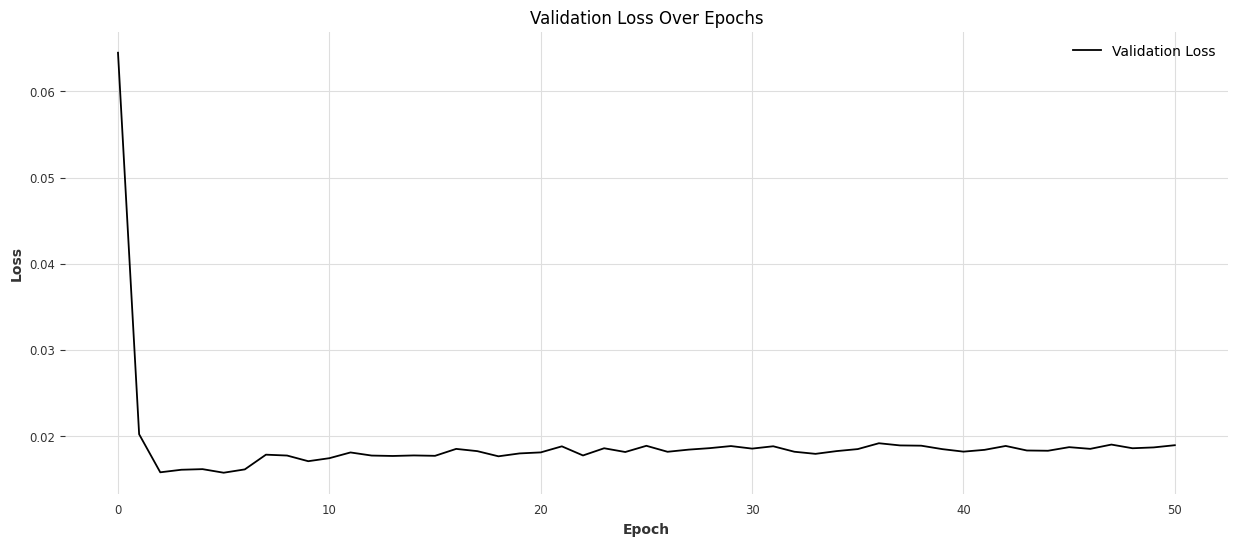

    Validation Loss
0          0.064500
1          0.020196
2          0.015776
3          0.016073
4          0.016143
5          0.015727
6          0.016114
7          0.017823
8          0.017723
9          0.017065
10         0.017414
11         0.018081
12         0.017721
13         0.017672
14         0.017735
15         0.017690
16         0.018494
17         0.018234
18         0.017634
19         0.017969
20         0.018088
21         0.018791
22         0.017733
23         0.018569
24         0.018133
25         0.018854
26         0.018159
27         0.018410
28         0.018583
29         0.018823
30         0.018527
31         0.018800
32         0.018164
33         0.017919
34         0.018239
35         0.018472
36         0.019151
37         0.018897
38         0.018867
39         0.018467
40         0.018176
41         0.018384
42         0.018837
43         0.018308
44         0.018278
45         0.018696
46         0.018499
47         0.018996
48         0.018569


In [172]:
# Step 2: Modify the model configuration to include the custom callback
loss_logging_callback = LossLoggingCallback()
model_TiDE = TiDEModel(
    input_chunk_length=1080,
    output_chunk_length=40,
    num_encoder_layers=3,
    num_decoder_layers=1,
    decoder_output_dim=32,
    hidden_size=256,
    temporal_decoder_hidden=32,
    use_layer_norm=True,
    dropout=0.08,
    random_state=42,
    batch_size=32,
    optimizer_kwargs = {
    "lr": 0.001,},
    pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 50,
    "accelerator": "auto",
    "enable_checkpointing": True,
    "callbacks": [loss_logging_callback,]},
    lr_scheduler_kwargs = {
    "gamma": 0.999},
    model_name="TiDE9",  #每次改變model_name以儲存weight
    save_checkpoints='/content/darts_logs/_model.pth.tar',
)

# After defining the model, proceed with the training as before
models = {
    "TiDE": model_TiDE,
}

model_TiDE.fit(
    series=[train],
    past_covariates=[ED_covariates],
    val_series=[val],
    val_past_covariates=[ED_covariates]
    #past_covariates=[WeekdayTrain, DayoffTrain]
    #enable_checkpointing=True,
)

# Step 3: Plotting the losses after training is completed
plt.figure(figsize=(15, 6))
plt.plot(loss_logging_callback.losses, label="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Alternatively, using pandas for a table view
df_losses = pd.DataFrame(loss_logging_callback.losses, columns=["Validation Loss"])
print(df_losses)

In [173]:
model_loaded = model_TiDE.load_from_checkpoint('TiDE9')

### 計算MAPE

In [174]:
from darts.metrics import mae, mse, mape
import matplotlib.pyplot as plt

In [175]:
# 進行預測
Model_prediction = model_TiDE.predict(len(series)-len(train), series=train, past_covariates=ED_covariates)
# invert scale, 資料格式轉換
Model_prediction_df = Model_prediction.pd_dataframe()
Model_prediction_df_inverse = scaler.inverse_transform(Model_prediction_df)
Model_prediction_df_inverse = pd.DataFrame(Model_prediction_df_inverse,
                      index=Model_prediction_df.index,
                      columns=Model_prediction_df.columns)

# 計算誤差
Model_prediction_ts_inverse = TimeSeries.from_dataframe(Model_prediction_df_inverse)
Model_mae = mae(test_origin, Model_prediction_ts_inverse)
Model_mse = mse(test_origin, Model_prediction_ts_inverse)
Model_mape = mape(test_origin, Model_prediction_ts_inverse)

print(Model_mae, Model_mse, Model_mape)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

39.7113164093881 2460.8774284770966 8.694797513554164


### Visualize

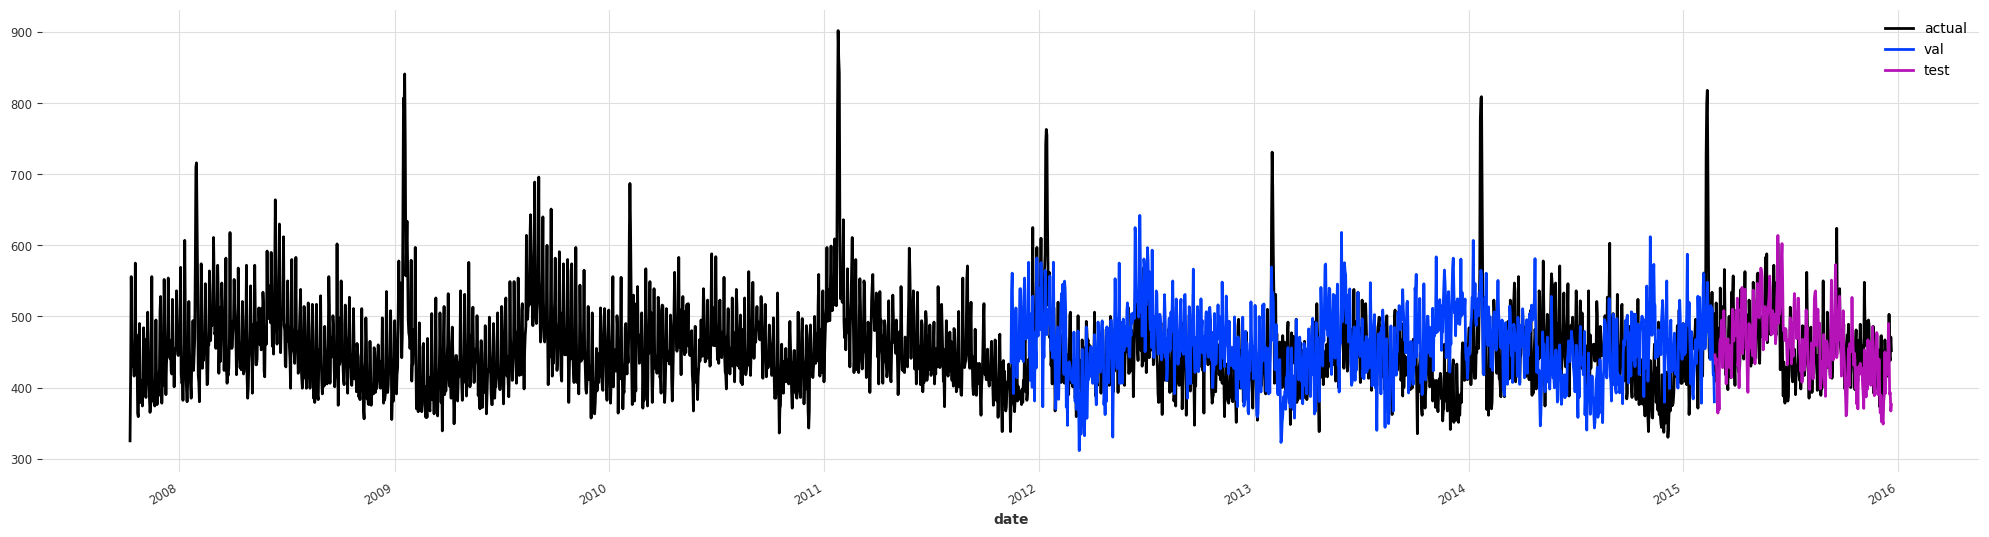

In [176]:
Model_prediction_val, Model_prediction_test = Model_prediction_ts_inverse.split_before(0.8)
plt.figure(figsize=(25, 6))
series_origin.plot(label='actual')
Model_prediction_val.plot(label='val')
Model_prediction_test.plot(label='test')

plt.legend()
plt.show()